In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV, cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import  XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor , RandomForestRegressor
from sklearn.metrics import r2_score


In [ ]:
car_data = pd.read_csv('car_price_prediction.csv')
car_data.head(1)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [ ]:
car_data.shape

(19237, 18)

In [ ]:
df = car_data.drop(['ID', 'Levy', 'Cylinders', 'Doors', 'Wheel', 'Color', 'Model', 'Airbags' ], axis=1)
df.head(3)

,Price,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Gear box type,Drive wheels
0,13328,LEXUS,2010,Jeep,Yes,Hybrid,3.5,186005 km,Automatic,4x4
1,16621,CHEVROLET,2011,Jeep,No,Petrol,3,192000 km,Tiptronic,4x4
2,8467,HONDA,2006,Hatchback,No,Petrol,1.3,200000 km,Variator,Front


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             19237 non-null  int64 
 1   Manufacturer      19237 non-null  object
 2   Prod. year        19237 non-null  int64 
 3   Category          19237 non-null  object
 4   Leather interior  19237 non-null  object
 5   Fuel type         19237 non-null  object
 6   Engine volume     19237 non-null  object
 7   Mileage           19237 non-null  object
 8   Gear box type     19237 non-null  object
 9   Drive wheels      19237 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.5+ MB


In [ ]:
df.shape

(19237, 10)

In [ ]:
df.describe()

,Price,Prod. year
count,1.923700e+04,19237.000000
mean,1.855593e+04,2010.912824
std,1.905813e+05,5.668673
min,1.000000e+00,1939.000000
25%,5.331000e+03,2009.000000
50%,1.317200e+04,2012.000000
75%,2.207500e+04,2015.000000
max,2.630750e+07,2020.000000


In [ ]:
df = df[(df['Price'] > 5000) & (df['Price'] < 200000)]

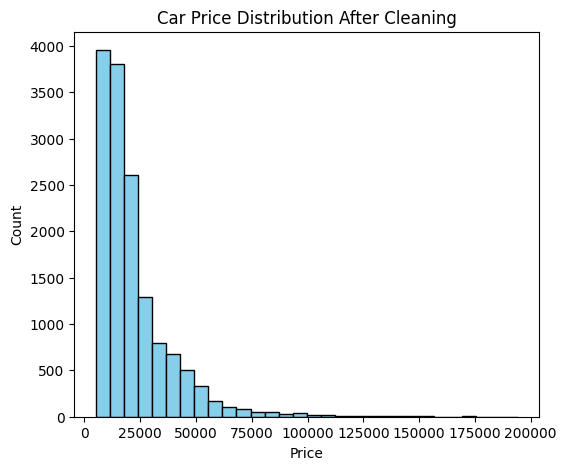

In [ ]:
plt.figure(figsize=(6,5))
plt.hist(df['Price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Car Price Distribution After Cleaning')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


In [ ]:
df['Manufacturer'] = df['Manufacturer'].replace('სხვა', 'Others')
counts = df['Manufacturer'].value_counts()
rare_counts = counts[counts < 100].index
df['Manufacturer'] = df['Manufacturer'].apply(lambda x : 'Others' if x in rare_counts else x )
df['Manufacturer'].head()


0        LEXUS
1    CHEVROLET
2        HONDA
4        HONDA
5      HYUNDAI
Name: Manufacturer, dtype: object

In [ ]:
df = df.rename(columns={'Prod. year': 'year'})
value_count = df['year'].value_counts()
rare_values = value_count[value_count < 50].index
median_year = df['year'].median()
df['year'] = df['year'].apply(lambda x : median_year if x in rare_values else x)
df['year'].value_counts().sort_index().head()

year
1995.0     50
1996.0     54
1997.0     87
1998.0    158
1999.0    168
Name: count, dtype: int64

In [ ]:
category_counts = df['Category'].value_counts()
rare_cateory = category_counts[category_counts < 100].index
df['Category'] = df['Category'].apply(lambda x : "Others" if x in rare_cateory else x)
df['Category'].value_counts()

Category
Sedan          6380
Jeep           4152
Hatchback      2137
Minivan         601
Coupe           437
Universal       340
Microbus        282
Goods wagon     192
Others           77
Name: count, dtype: int64

In [ ]:
df['Leather interior'] = df['Leather interior'].map({'Yes': 1, 'No': 0})
df['Leather interior'].value_counts()

Leather interior
1    10048
0     4550
Name: count, dtype: int64

In [ ]:
df['Fuel type'].value_counts()

Fuel type
Petrol            7622
Diesel            3490
Hybrid            2152
LPG                869
CNG                379
Plug-in Hybrid      85
Hydrogen             1
Name: count, dtype: int64

In [ ]:
fuel_type_count = df['Fuel type'].value_counts()
rare_types = fuel_type_count[fuel_type_count < 100].index
df['Fuel type'] = df['Fuel type'].apply(lambda x: 'Others' if x in rare_types else x)
df['Fuel type'] = df['Fuel type'].map({'Petrol': 0, 'Diesel':1, 'Hybrid':2, 'LPG':3, 'CNG':4, 'Others':5})
df['Fuel type'].value_counts()

Fuel type
0    7622
1    3490
2    2152
3     869
4     379
5      86
Name: count, dtype: int64

In [ ]:
df['Engine volume'].value_counts()


Engine volume
2            3267
2.5          1642
1.6          1224
1.8          1199
1.5          1098
             ... 
5.4 Turbo       1
0.3 Turbo       1
0.9             1
5.2             1
5.8             1
Name: count, Length: 99, dtype: int64

In [ ]:
df['Engine volume'] = df['Engine volume'].apply(lambda x:x.split(' ')[0])
df['Engine volume'] = df['Engine volume'].astype(float)
engine_count = df['Engine volume'].value_counts()
rare_engine = engine_count[engine_count <= 700].index
df['Engine volume'] = df['Engine volume'].apply(lambda x : 1.5 if x in rare_engine else x)
df['Engine volume'].value_counts()

Engine volume
1.5    5700
2.0    3665
2.5    1730
1.8    1362
1.6    1340
3.0     801
Name: count, dtype: int64

In [ ]:
df = df.rename(columns={'Mileage': 'Mileage(Km)'})
df['Mileage(Km)'] = df['Mileage(Km)'].apply(lambda x: str(x).split(" ")[0])
df['Mileage(Km)'] = df['Mileage(Km)'].astype(float)
df= df[df['Mileage(Km)'] != 0]
df['Mileage(Km)'].value_counts()


Mileage(Km)
200000.0    149
150000.0    124
160000.0    113
180000.0     98
170000.0     88
           ... 
65691.0       1
158130.0      1
23430.0       1
132700.0      1
140607.0      1
Name: count, Length: 6082, dtype: int64

In [ ]:
df = df.rename(columns={'Gear box type': 'Gear Type'})
df['Gear Type'] = df['Gear Type'].map({'Manual':0, 'Automatic':1, 'Tiptronic':2, 'Variator':3})
df['Gear Type'].value_counts()

Gear Type
1    9276
2    2917
0    1328
3     684
Name: count, dtype: int64

In [ ]:
df['Drive wheels'] = df['Drive wheels'].map({'4x4':0, 'Front':1, 'Rear':2})
df['Drive wheels'].value_counts()

Drive wheels
1    9918
0    2621
2    1666
Name: count, dtype: int64

In [ ]:
df.head()

,Price,Manufacturer,year,Category,Leather interior,Fuel type,Engine volume,Mileage(Km),Gear Type,Drive wheels
0,13328,LEXUS,2010.0,Jeep,1,2,1.5,186005.0,1,0
1,16621,CHEVROLET,2011.0,Jeep,0,0,3.0,192000.0,2,0
2,8467,HONDA,2006.0,Hatchback,0,0,1.5,200000.0,3,1
4,11726,HONDA,2014.0,Hatchback,1,0,1.5,91901.0,1,1
5,39493,HYUNDAI,2016.0,Jeep,1,1,2.0,160931.0,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14205 entries, 0 to 19235
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             14205 non-null  int64  
 1   Manufacturer      14205 non-null  object 
 2   year              14205 non-null  float64
 3   Category          14205 non-null  object 
 4   Leather interior  14205 non-null  int64  
 5   Fuel type         14205 non-null  int64  
 6   Engine volume     14205 non-null  float64
 7   Mileage(Km)       14205 non-null  float64
 8   Gear Type         14205 non-null  int64  
 9   Drive wheels      14205 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 1.2+ MB


In [ ]:
df.describe()

,Price,year,Leather interior,Fuel type,Engine volume,Mileage(Km),Gear Type,Drive wheels
count,14205.00000,14205.000000,14205.000000,14205.000000,14205.000000,1.420500e+04,14205.000000,14205.000000
mean,22073.92559,2011.211616,0.694544,0.841112,1.864414,1.147185e+06,1.208166,0.932770
std,17267.15598,4.872566,0.460616,1.093631,0.425095,4.287411e+07,0.669436,0.545249
min,5015.00000,1995.000000,0.000000,0.000000,1.500000,1.300000e+01,0.000000,0.000000
25%,11000.00000,2009.000000,0.000000,0.000000,1.500000,7.260900e+04,1.000000,1.000000
50%,17158.00000,2012.000000,1.000000,0.000000,1.800000,1.233330e+05,1.000000,1.000000
75%,26657.00000,2015.000000,1.000000,1.000000,2.000000,1.800030e+05,2.000000,1.000000
max,194438.00000,2019.000000,1.000000,5.000000,3.000000,2.147484e+09,3.000000,2.000000


In [ ]:
df.shape

(14205, 10)

In [ ]:
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numerical_features = [col for col in X.columns if X[col].dtypes in ['int64', 'float64']]
categorical_features = [col for col in X.columns if X[col].dtypes in ['object', 'category']]

print("Numerical:", numerical_features)
print("Categorical:", categorical_features)

Numerical: ['year', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage(Km)', 'Gear Type', 'Drive wheels']
Categorical: ['Manufacturer', 'Category']


In [ ]:
preprocessing = ColumnTransformer([
    ('num' , StandardScaler() , numerical_features),
    ('cate' , OneHotEncoder() , categorical_features)
])

In [ ]:
models = {
    'LinearRegression' : LinearRegression(),
    'DecisionTreeRegressor' : DecisionTreeRegressor(),
    'KNeighborsRegressor' : KNeighborsRegressor(),
    'GradientBoostingRegressor' : GradientBoostingRegressor(),
    'XGBRegressor' : XGBRegressor(),
    'RandomForestRegressor' : RandomForestRegressor()
}

In [ ]:
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing' , preprocessing),
        ('model' , model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, n_jobs=-1, scoring='r2')  
    mean_r2 = scores.mean()
    print(f"{name}: R² score = {mean_r2:.4f}")


LinearRegression: R² score = 0.3542
DecisionTreeRegressor: R² score = 0.3135
KNeighborsRegressor: R² score = 0.5565
GradientBoostingRegressor: R² score = 0.5208
XGBRegressor: R² score = 0.6017
RandomForestRegressor: R² score = 0.6090


In [ ]:


# Hyperparameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [None, 5, 7, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 0.8]  # optional
}


In [ ]:
# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=2,
    n_jobs=-1,
    scoring='r2'
)


In [ ]:
# Fit on training data
grid_search.fit(X_train, y_train)


In [ ]:
# Best model and parameters
best_rf = grid_search.best_estimator_
print("Best R² (CV):", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred = best_rf.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))


Best R² (CV): 0.6157170949598587
Best Parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Test R²: 0.6594676950332825


In [ ]:
import joblib

# Save the trained pipeline
joblib.dump(pipeline, 'car_price_model.pkl')
print("✅ Model saved successfully!")


✅ Model saved successfully!
